# Researching Movie Ratings on Fandango

Fandango is a website that displays movie ratings on a 5-star scale, where 0 is the minimum rating and 5 is the maximum rating.  Back in 2015, a data journalist named Walk Hickey found [strong evidence](https://fivethirtyeight.com/features/fandango-movies-ratings/) suggesting that Fandango's movie rating system was biased and dishonest.  He noticed significant discrepancies between the ratings displayed on the webpages and the actual ratings in the HTMLs of the webpages.  More specifically, he found:

* The actual rating was almost always rounded up to the nearest *half*-star.
    - For example, a 4.1-rated movie would be rounded up to 4.5 instead of 4.
* Rounding up to the nearest *whole* star was done to 8% of ratings.
    - For example, a 4.5-rated movie would be rounded up to 5 stars instead of remaining at 4.5.
    
These adjustments suggested that Fandago inflated movie star ratings under the hood, resulting in higher ratings on the site than what they actually were.  Fandago claimed that this biased rounding was due to a bug in their system and promised to fix it immediately.  Presumably the error has been corrected, but it can no longer be confirmed since the actual ratings are no longer in the HTML pages.

**Objective:** In this project, we'll analyze more recent movie ratings to determine whether Fandango's system has changed after Hickey's findings.

## Exploring the data

We first read two datasets into pandas dataframes, view information about them briefly, and create copies with only the columns of interest.  One dataset contains a sample of movie ratings *prior* to Hickey's analysis, and the other dataset contains a sample of movie ratings *after* Hickey's analysis (to determine if Fandango changed their rating system).

In [1]:
# Read in the datasets
import pandas as pd

prior_ratings = pd.read_csv("fandango_score_comparison.csv")
current_ratings = pd.read_csv("movie_ratings_16_17.csv")

In [2]:
# Print information on the 'prior_ratings' dataset
prior_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        146 non-null    object 
 1   RottenTomatoes              146 non-null    int64  
 2   RottenTomatoes_User         146 non-null    int64  
 3   Metacritic                  146 non-null    int64  
 4   Metacritic_User             146 non-null    float64
 5   IMDB                        146 non-null    float64
 6   Fandango_Stars              146 non-null    float64
 7   Fandango_Ratingvalue        146 non-null    float64
 8   RT_norm                     146 non-null    float64
 9   RT_user_norm                146 non-null    float64
 10  Metacritic_norm             146 non-null    float64
 11  Metacritic_user_nom         146 non-null    float64
 12  IMDB_norm                   146 non-null    float64
 13  RT_norm_round               146 non

In [3]:
# Print information on the 'current_ratings' dataset
current_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie         214 non-null    object 
 1   year          214 non-null    int64  
 2   metascore     214 non-null    int64  
 3   imdb          214 non-null    float64
 4   tmeter        214 non-null    int64  
 5   audience      214 non-null    int64  
 6   fandango      214 non-null    float64
 7   n_metascore   214 non-null    float64
 8   n_imdb        214 non-null    float64
 9   n_tmeter      214 non-null    float64
 10  n_audience    214 non-null    float64
 11  nr_metascore  214 non-null    float64
 12  nr_imdb       214 non-null    float64
 13  nr_tmeter     214 non-null    float64
 14  nr_audience   214 non-null    float64
dtypes: float64(10), int64(4), object(1)
memory usage: 25.2+ KB


In [4]:
# Reduce the number of columns to those necessary for this analysis
prior_ratings_trunc = prior_ratings[["FILM", "Fandango_Stars", "Fandango_Ratingvalue",
                                     "Fandango_votes", "Fandango_Difference"]].copy()
current_ratings_trunc = current_ratings[["movie", "year", "fandango"]].copy()

## Review of population and samples

We're interested in *all* movie ratings on Fandango's website, regardless of the year it was released, which would define our population.  The datasets we have represent samples of movies *before* and *after* Hickey's analysis.  This is great, because we want the ability to compare results to see if Fandango made any rating system changes to between time periods.  

It is important for samples to be *representative* of the population, otherwise the sampling error could be significantly large.  Such a sampling error may result in an analysis that does not generalize well enough, forming invalid conclusions.  From the `README.md` sections of the data repositories, we find that the samples were not chosen randomly and instead are based on criteria.

Sampling criteria for the [first](https://github.com/fivethirtyeight/data/tree/master/fandango) dataset include:
* Movie had 30+ ratings (at the time of sampling)
* Movie had tickets for sale in 2015

Sampling criteria for the [second](https://github.com/mircealex/Movie_ratings_2016_17) dataset include:
* Movie was released in 2016 or later
* Movie had "considerable" votes and reviews

These sampling criteria result in samples that are subject to temporal trends and may not be *representative* of our population.  Rather than collecting new data, we will simply place a scope limitation on the objective, which should remain a good proxy for our initial objective.

## Changing our objective (slightly)

**Objective:** In this project, we'll analyze more recent **popular** movie ratings (defined as 30+ movie ratings) to determine whether Fandango's system has changed after Hickey's findings.

Next, we check that our datasets represent the correct information and clean them as needed.

In [5]:
# Check for any movies with non-credible number of ratings
sum(prior_ratings_trunc["Fandango_votes"] < 30)

0

In [6]:
# Check the years of movies released in first dataset
prior_ratings_trunc["Year"] = prior_ratings_trunc["FILM"].str[-5:-1]
prior_ratings_trunc["Year"].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

In [7]:
# Remove movies that were released outside of 2015
prior_ratings_trunc_2015 = prior_ratings_trunc[prior_ratings_trunc["Year"] == "2015"].copy()
prior_ratings_trunc_2015["Year"].value_counts()

2015    129
Name: Year, dtype: int64

In [8]:
# Check the years of movies released in second dataset
current_ratings_trunc["year"].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [9]:
# Remove movies that were released outside of 2016
current_ratings_trunc_2016 = current_ratings_trunc[current_ratings_trunc["year"] == 2016].copy()
current_ratings_trunc_2016["year"].value_counts()

2016    191
Name: year, dtype: int64

## Analysis of the two distributions (kernel density plots)

Now that our data is clean and correct, we can start analyzing it.  First, we create a graphical view of the distributions using overlapping kernel density plots.

Text(0.5, 0, 'Stars')

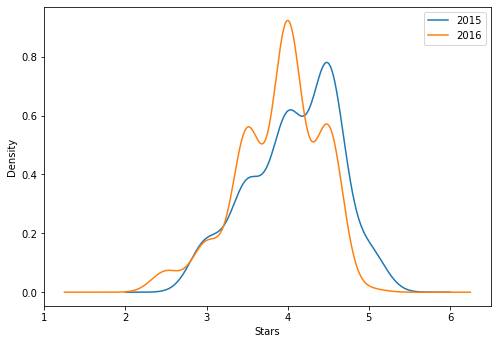

In [10]:
# Produce overlapping kernel density plots of both distributions of movie ratings
import matplotlib.pyplot as plt
%matplotlib inline

prior_ratings_trunc_2015["Fandango_Stars"].plot.kde(label = "2015", legend = True, figsize = (8, 5.5))
current_ratings_trunc_2016["fandango"].plot.kde(label = "2016", legend = True)

plt.xlabel("Stars")

It can easily be seen in the distribution plots above that the movie ratings generally decreased in 2016 (from 2015).

## Frequency distributions of Fandango movie ratings

We now take a closer look at the frequency distributions of movie ratings (0-5) on Fandango.

In [11]:
# Generate frequency distribution of first dataset as percentages
prior_ratings_trunc_2015["Fandango_Stars"].value_counts(normalize = True).sort_index()

3.0    0.085271
3.5    0.178295
4.0    0.286822
4.5    0.379845
5.0    0.069767
Name: Fandango_Stars, dtype: float64

In [12]:
# Generate frequency distribution of second dataset as percentages
current_ratings_trunc_2016["fandango"].value_counts(normalize = True).sort_index()

2.5    0.031414
3.0    0.073298
3.5    0.240838
4.0    0.403141
4.5    0.246073
5.0    0.005236
Name: fandango, dtype: float64

The frequency distribution tables are further confirm the difference in movie ratings between years.  There are more movies (proportionally) with higher ratings in 2015 compared to 2016.

## Summary statistics

Finally, we look at three summary statistics for each distribution as an additional comparison.

In [13]:
# Calculate mean, median, and mode for both distributions
mean_2015 = prior_ratings_trunc_2015["Fandango_Stars"].mean()
mean_2016 = current_ratings_trunc_2016["fandango"].mean()
median_2015 = prior_ratings_trunc_2015["Fandango_Stars"].median()
median_2016 = current_ratings_trunc_2016["fandango"].median()
mode_2015 = prior_ratings_trunc_2015["Fandango_Stars"].mode()[0]
mode_2016 = current_ratings_trunc_2016["fandango"].mode()[0]

# Consolidate statistics into two pandas dataframes (one for each year)
summary = pd.DataFrame()
summary["2015"] = [mean_2015, median_2015, mode_2015]
summary["2016"] = [mean_2016, median_2016, mode_2016]
summary.index = ["Mean", "Median", "Mode"]
summary

,2015,2016
Mean,4.085271,3.887435
Median,4.000000,4.000000
Mode,4.500000,4.000000


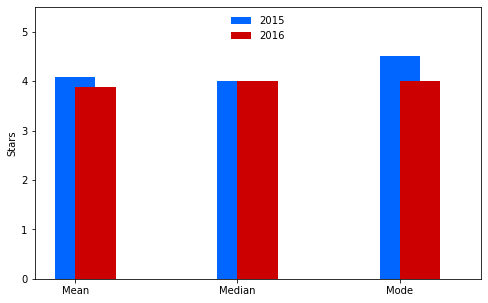

In [14]:
# Plot summary statistics of both years
summary["2015"].plot.bar(color = '#0066FF', align = 'center', label = '2015', width = .25)
summary["2016"].plot.bar(color = '#CC0000', align = 'edge', label = '2016', width = .25,
                         rot = 0, figsize = (8,5))

plt.legend(framealpha = 0, loc = 'upper center')
plt.ylim(0, 5.5)
plt.ylabel("Stars")

plt.show()

## Conclusion

The summary statistics plotted above triple confirm that the Fandango movie rating system has changed from 2015 to 2016.  Both the mean and the mode are noticeably lower in 2016, indicating that movie ratings were inflated in 2015.